In [0]:
#@title ##### License
# Copyright 2018 The GraphNets Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#    http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or  implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ============================================================================

# Find the hamiltonian path in a graph
This notebook and the accompanying code demonstrates how to use the Graph Nets library to learn to predict the shortest path between two nodes in graph.

The network is trained to label the nodes and edges of the shortest path, given the start and end nodes.

After training, the network's prediction ability is illustrated by comparing its output to the hamiltonian path generated with the graph. 

In [2]:
#@title ### Install the Graph Nets library on this Colaboratory runtime  { form-width: "60%", run: "auto"}
#@markdown <br>1. Connect to a local or hosted Colaboratory runtime by clicking the **Connect** button at the top-right.<br>2. Choose "Yes" below to install the Graph Nets library on the runtime machine with:<br> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;```pip install graph_nets```<br> Note, this works both with local and hosted Colaboratory runtimes.

install_graph_nets_library = "Yes"  #@param ["Yes", "No"]

if install_graph_nets_library.lower() == "yes":
  print("Installing Graph Nets library with:")
  print("  $ pip install graph_nets\n")
  print("Output message from command:\n")
  !pip install graph_nets
else:
  print("Skipping installation of Graph Nets library")

Installing Graph Nets library with:
  $ pip install graph_nets

Output message from command:



### Install dependencies locally

If you are running this notebook locally (i.e., not through Colaboratory), you will also need to install a few more dependencies. Run the following on the command line to install the graph networks library, as well as a few other dependencies:

```
pip install graph_nets matplotlib scipy
```

# Code

In [3]:
#@title Imports  { form-width: "30%" }

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import itertools
import time

from graph_nets import graphs
from graph_nets import utils_np
from graph_nets import utils_tf
from graph_nets.demos import models
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from scipy import spatial
import tensorflow as tf

SEED = 1
np.random.seed(SEED)
tf.set_random_seed(SEED)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [0]:
#@title Helper functions  { form-width: "30%" }

# pylint: disable=redefined-outer-name


def print_graph(g):
    for s, t, w in g.edges(data=True):
        if 'features' not in w:
            print(s, t, w, "(problem)")
        else:
            print(s, t, w, "(ok)")

def print_graphs(gs):
    for g in gs:
        print("----------------------------------------------------------------------------")
        print_graph(g)
        print("----------------------------------------------------------------------------")

DISTANCE_WEIGHT_NAME = "distance"  # The name for the distance edge attribute.


def pairwise(iterable):
    """s -> (s0,s1), (s1,s2), (s2, s3), ..."""
    a, b = itertools.tee(iterable)
    next(b, None)
    return zip(a, b)

def set_diff(seq0, seq1):
    """Return the set difference between 2 sequences as a list."""
    return list(set(seq0) - set(seq1))

def to_one_hot(indices, max_value, axis=-1):
    one_hot = np.eye(max_value)[indices]
    if axis not in (-1, one_hot.ndim):
        one_hot = np.moveaxis(one_hot, -1, axis)
    return one_hot

def create_feature(feature, fields):
    return np.hstack([np.array(feature[field], dtype=float) for field in fields])

def generate_raw_graph(
    rand,
    min_max_nodes,
    dimensions=2,
    geo_density=None,
    node_rate=1.0,
    min_length=1,
    permute=False
):
    """Creates a connected graph.

    The graphs are geographic threshold graphs, but with added edges via a
    minimum spanning tree algorithm, to ensure all nodes are connected.

    Args:
        rand: A random seed for the graph generator. Default= None.
        min_max_nodes: A sequence [lower, upper) number of nodes per graph.
        dimensions: (optional) An `int` number of dimensions for the positions.
            Default= 2.
        geo_density: (optional) A `float` threshold parameters for the geographic
            threshold graph's threshold. Large values (1000+) make mostly trees. Try
            20-60 for good non-trees. Default=1000.0.
        node_rate: (optional) A node_rate parameter for the node weight exponential sampling
            distribution. Default= 1.0.

    Returns:
        The graph.
    """
    min_nodes, max_nodes = min_max_nodes
    if not geo_density:
        geo_density=(min_nodes+max_nodes)/2.0

    # Sample num_nodes.
    num_nodes = rand.randint(min_nodes, max_nodes)
    pos_array = np.arange(num_nodes)
    pos_array = (2 * np.pi * pos_array ) / num_nodes
    pos_array = np.array([np.cos(pos_array), np.sin(pos_array)])
    pos_array = pos_array.transpose()
    #pos_array = rand.uniform(size=(num_nodes, dimensions))
    weight_array = rand.exponential(node_rate, size=num_nodes)

    # Create geographic threshold graph.
    geo_graph = nx.geographical_threshold_graph(
        num_nodes,
        10.0/geo_density,
        pos=dict(enumerate(pos_array)),
        weight=dict(enumerate(weight_array))
    )
    #geo_graph = nx.complement(geo_graph)

    cycle_graph = nx.DiGraph()
    nodes = np.array(geo_graph.nodes())
    rand.shuffle(nodes)
    nodes = list(nodes)
    cycle_graph.add_cycle(nodes)


    # Compose the graphs.
    graph = nx.compose_all((cycle_graph, geo_graph.copy().to_directed()))

    # Put geo_graph's node attributes into the cycle_graph.
    for v in cycle_graph.nodes():
        graph.node[v].update(geo_graph.node[v])

    # Put all distance weights into edge attributes.
    graph.add_nodes_from(set_diff(graph.nodes(), cycle_graph.nodes()), solution=False)
    graph.add_nodes_from(cycle_graph.nodes(), solution=True)
    graph.add_edges_from(set_diff(graph.edges(), cycle_graph.edges()), solution=False)
    graph.add_edges_from(cycle_graph.edges(), solution=True)

    for u, v in graph.edges():
        graph[u][v][DISTANCE_WEIGHT_NAME] = rand.random_sample()
    
    if permute:
        graph = nx.relabel_nodes(graph, mapping={i: p for i,p in enumerate(np.random.permutation(len(graph)))})

    return graph

def generate_raw_graphs(rand, num_examples, min_max_nodes, geo_density, permute=False):
    return [generate_raw_graph(rand, min_max_nodes, geo_density=geo_density, permute = permute) for _ in range(num_examples)]


In [0]:
#@title Graph Plot Helper Class  { form-width: "30%" }

def get_node_dict(graph, attr):
    """Return a `dict` of node:attribute pairs from a graph."""
    return {k: v[attr] for k, v in graph.node.items()}

# pylint: disable=redefined-outer-name
class GraphPlotter(object):

    def __init__(self, ax, graph):
        self._ax = ax
        self._graph = graph
        self._pos = get_node_dict(graph, "pos")
        self._base_draw_kwargs = dict(G=self._graph, pos=self._pos, ax=self._ax)
        self._solution_length = None
        self._nodes = None
        self._edges = None
        self._start_nodes = None
        self._end_nodes = None
        self._solution_nodes = None
        self._intermediate_solution_nodes = None
        self._solution_edges = None
        self._non_solution_nodes = None
        self._non_solution_edges = None
        self._ax.set_axis_off()

    @property
    def solution_length(self):
        if self._solution_length is None:
            self._solution_length = len(self._solution_edges)
        return self._solution_length

    @property
    def nodes(self):
        if self._nodes is None:
            self._nodes = self._graph.nodes()
        return self._nodes

    @property
    def edges(self):
        if self._edges is None:
            self._edges = self._graph.edges()
        return self._edges

    @property
    def start_nodes(self):
        if self._start_nodes is None:
            self._start_nodes = [
                n for n in self.nodes
                if self._graph.node[n].get("start", False)
            ]
        return self._start_nodes

    @property
    def end_nodes(self):
        if self._end_nodes is None:
            self._end_nodes = [
                n for n in self.nodes
                if self._graph.node[n].get("end", False)
            ]
        return self._end_nodes

    @property
    def solution_nodes(self):
        if self._solution_nodes is None:
            self._solution_nodes = [
                n for n in self.nodes
                if self._graph.node[n].get("solution", False)
            ]
        return self._solution_nodes

    @property
    def intermediate_solution_nodes(self):
        if self._intermediate_solution_nodes is None:
            self._intermediate_solution_nodes = [
                    n for n in self.nodes
                    if self._graph.node[n].get("solution", False) and
                    not self._graph.node[n].get("start", False) and
                    not self._graph.node[n].get("end", False)
            ]
        return self._intermediate_solution_nodes

    @property
    def solution_edges(self):
        if self._solution_edges is None:
            self._solution_edges = [
                    e for e in self.edges
                    if self._graph.get_edge_data(e[0], e[1]).get("solution", False)
            ]
        return self._solution_edges

    @property
    def non_solution_nodes(self):
        if self._non_solution_nodes is None:
            self._non_solution_nodes = [
                    n for n in self.nodes
                    if not self._graph.node[n].get("solution", False)
            ]
        return self._non_solution_nodes

    @property
    def non_solution_edges(self):
        if self._non_solution_edges is None:
            self._non_solution_edges = [
                e for e in self.edges
                if not self._graph.get_edge_data(e[0], e[1]).get("solution", False)
            ]
        return self._non_solution_edges

    def _make_draw_kwargs(self, **kwargs):
        kwargs.update(self._base_draw_kwargs)
        return kwargs

    def _draw(self, draw_function, zorder=None, **kwargs):
        draw_kwargs = self._make_draw_kwargs(**kwargs)
        collection = draw_function(**draw_kwargs)
        if type(collection) is list:
            # This is for compatibility with newer matplotlib.
            collection = collection[0]

        if collection is not None and zorder is not None:
            collection.set_zorder(zorder)
        return collection

    def draw_nodes(self, **kwargs):
        """Useful kwargs: nodelist, node_size, node_color, linewidths."""
        if (
            "node_color" in kwargs and
            isinstance(kwargs["node_color"], collections.Sequence) and
            len(kwargs["node_color"]) in {3, 4} and
            not isinstance(
                kwargs["node_color"][0],
                (collections.Sequence, np.ndarray)
            )
        ):
            num_nodes = len(kwargs.get("nodelist", self.nodes))
            kwargs["node_color"] = np.tile(
                np.array(kwargs["node_color"])[None],
                [num_nodes, 1]
            )
        return self._draw(nx.draw_networkx_nodes, **kwargs)

    def draw_edges(self, **kwargs):
        """Useful kwargs: edgelist, width."""
        return self._draw(nx.draw_networkx_edges, **kwargs)

    def draw_graph(
        self,
        node_size=200,
        node_color=(0.4, 0.8, 0.4),
        node_linewidth=1.0,
        edge_width=1.0
    ):
        # Plot nodes.
        self.draw_nodes(
            nodelist=self.nodes,
            node_size=node_size,
            node_color=node_color,
            linewidths=node_linewidth,
            zorder=20
        )
        # Plot edges.
        self.draw_edges(
            edgelist=self.edges,
            width=edge_width,
            zorder=10
        )

    def draw_graph_with_solution(
        self,
        node_size=200,
        node_color=(0.5, 0.7, 0.5),
        node_linewidth=1.0,
        start_color="w",
        end_color="k",
        edge_width=1.0,
        edge_style = "dashed",
        solution_node_color = (0.2, 1.0, 0.2),
        solution_node_linewidth=3.0,
        solution_edge_width=3.0,
        solution_edge_style = "solid"
    ):
        node_border_color = (0.0, 0.0, 0.0, 1.0)
        node_collections = {}
        # Plot start nodes.
        node_collections["start nodes"] = self.draw_nodes(
            nodelist=self.start_nodes,
            node_size=node_size,
            node_color=start_color,
            linewidths=solution_node_linewidth,
            edgecolors=node_border_color,
            zorder=100
        )
        # Plot end nodes.
        node_collections["end nodes"] = self.draw_nodes(
            nodelist=self.end_nodes,
            node_size=node_size,
            node_color=end_color,
            linewidths=solution_node_linewidth,
            edgecolors=node_border_color,
            zorder=90
        )
        # Plot intermediate solution nodes.
        if isinstance(node_color, dict):
            c = [node_color[n] for n in self.intermediate_solution_nodes]
        else:
            c = solution_node_color
        node_collections["intermediate solution nodes"] = self.draw_nodes(
            nodelist=self.intermediate_solution_nodes,
            node_size=node_size,
            node_color=c,
            linewidths=solution_node_linewidth,
            edgecolors=node_border_color,
            zorder=80
        )
        # Plot solution edges.
        node_collections["solution edges"] = self.draw_edges(
            edgelist=self.solution_edges,
            width=solution_edge_width,
            style=solution_edge_style,
            zorder=70
        )
        # Plot non-solution nodes.
        if isinstance(node_color, dict):
            c = [node_color[n] for n in self.non_solution_nodes]
        else:
            c = node_color
        node_collections["non-solution nodes"] = self.draw_nodes(
            nodelist=self.non_solution_nodes,
            node_size=node_size,
            node_color=c,
            linewidths=node_linewidth,
            edgecolors=node_border_color,
            zorder=20
        )
        # Plot non-solution edges.
        node_collections["non-solution edges"] = self.draw_edges(
            edgelist=self.non_solution_edges,
            width=edge_width,
            style=edge_style,
            zorder=10
        )
        # Set title as solution length.
        self._ax.set_title("Solution length: {}".format(self.solution_length))
        return node_collections


# pylint: enable=redefined-outer-name

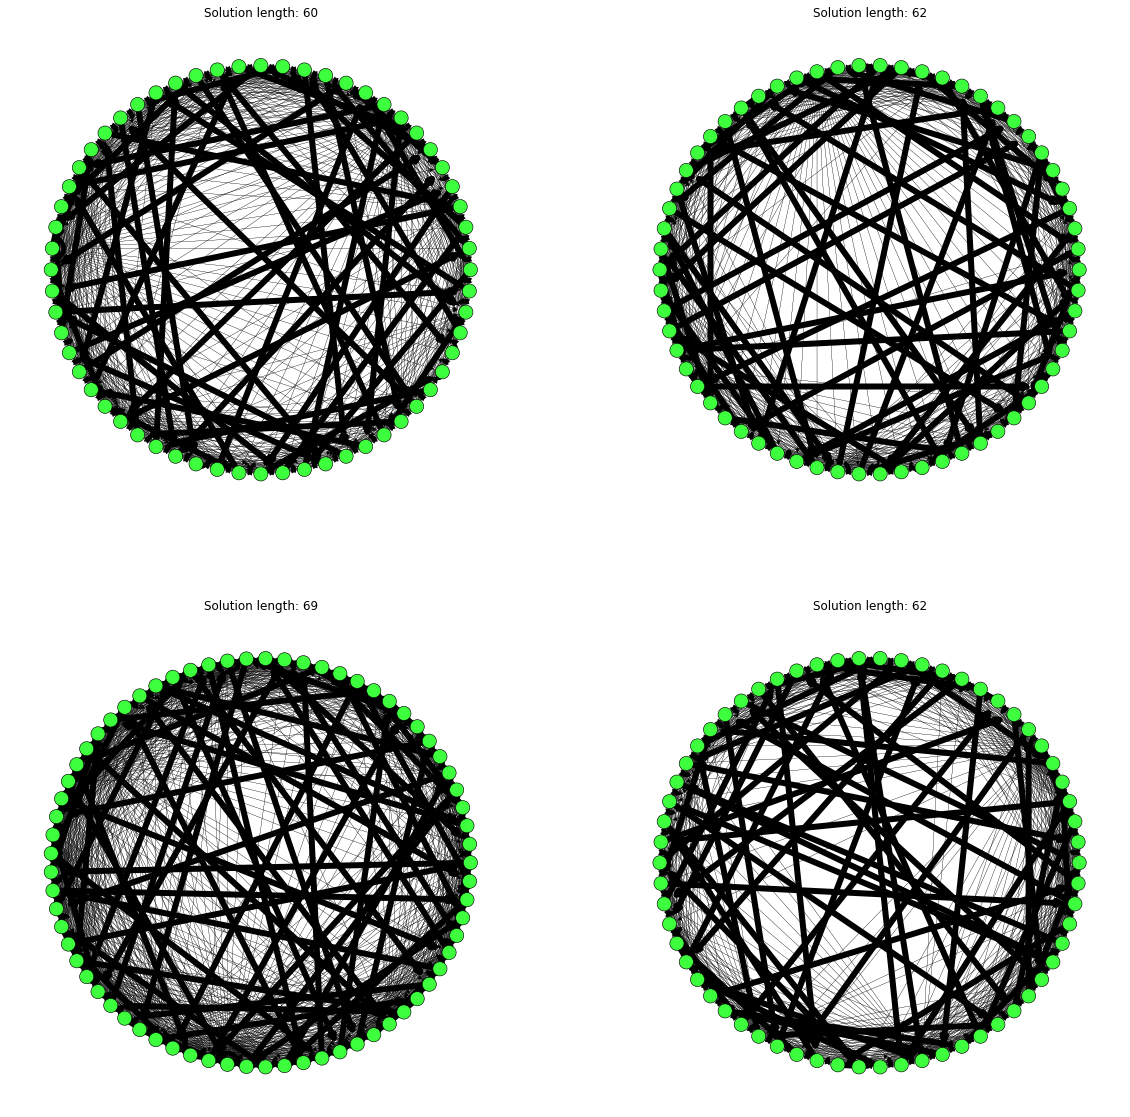

In [6]:
#@title #Visualize example graphs  { form-width: "30%" }
def rgb_from_hex(h):
    if h[0] != '#' or len(h) != 7:
        raise ValueError("'{}' should be '#' followed by 6 HEX chars".format(h))
    h = h.lstrip('#')
    h = h.upper()
    invalid_chars = set(list(h)) - set(list("0123456789ABCDEF"))
    if invalid_chars:
        raise ValueError("Incorrect chars: \{{}\}".format(', '.format(invalid_chars)))
    return tuple(int(h[i:i+2], 16)/255.0 for i in [0, 2 ,4])

#@markdown ##General Vizual Params

node_size=200 #@param{type:"slider", min:128, max:2048, step:1}
node_hex_color = "#808080" #@param {type:"string"}
node_color = rgb_from_hex(node_hex_color)
node_linewidth=1.0 #@param{type:"slider", min:0.1, max:3.0, step:0.1}
edge_width=0.2 #@param{type:"slider", min:0.1, max:3.0, step:0.1}
edge_style = "dashed" #@param ["solid", "dashed", "dotted", "dashdot"]
start_color="w"
end_color="k"

#@markdown ##Solution Vizual Paramters
solution_node_hex_color = "#3DFF3D" #@param {type:"string"}
solution_node_color = rgb_from_hex(solution_node_hex_color)
solution_node_linewidth=0.6 #@param{type:"slider", min:0.1, max:6.0, step:0.1}
solution_edge_width=6.0 #@param{type:"slider", min:0.1, max:4.0, step=0.1}
solution_edge_style = "solid" #@param ["solid", "dashed", "dotted", "dashdot"]


#@markdown ##Specific Parameters

seed = 5  #@param{type: 'integer'}
rand = np.random.RandomState(seed=seed)

num_examples = 4  #@param{type: 'integer'}


min_nodes = 57 #@param {type:"slider", min:4, max:256, step:1}
max_nodes = 83 #@param {type:"slider", min:4, max:256, step:1}

theta = 7.1  #@param{type:"slider", min:0.1, max:64, step:1}
#@markdown Large values (1000+) make trees. Try 20-60 for good non-trees.

horizontal_length = 20 #@param{type: 'integer'}
graphs_per_column = 2 #@param{type: 'integer'}

min_max_nodes = (min_nodes, max_nodes)

graphs = generate_raw_graphs(
    rand,
    num_examples,
    min_max_nodes,
    theta
)

num = min(num_examples, 16)
size = horizontal_length/graphs_per_column
w = graphs_per_column
h = int(np.ceil(num / w))
fig = plt.figure(40, figsize=(w * size, h * size))
fig.clf()
for j, graph in enumerate(graphs):
    ax = fig.add_subplot(h, w, j + 1)
    plotter = GraphPlotter(ax, graph)
    plotter.draw_graph_with_solution(
        node_size=node_size,
        node_color=node_color,
        node_linewidth=node_linewidth,
        start_color=start_color,
        end_color=end_color,
        edge_width=edge_width,
        edge_style=edge_style,
        solution_node_color=solution_node_color,
        solution_node_linewidth=solution_node_linewidth,
        solution_edge_width=solution_edge_width,
        solution_edge_style=solution_edge_style
    )


In [0]:
#@title Model definition { form-width: "20%" }

# Copyright 2018 The GraphNets Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#    http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or  implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ============================================================================
"""Model architectures for the demos."""

import sonnet as snt

NUM_LAYERS = 2  # Hard-code number of layers in the edge/node/global models.
LATENT_SIZE = 16  # Hard-code latent layer sizes for demos.


def make_mlp_model():
    """Instantiates a new MLP, followed by LayerNorm.

    The parameters of each new MLP are not shared with others generated by
    this function.

    Returns:
        A Sonnet module which contains the MLP and LayerNorm.
    """
    return snt.Sequential([
            snt.nets.MLP([LATENT_SIZE] * NUM_LAYERS, activate_final=True),
            snt.LayerNorm()
    ])


class MLPGraphIndependent(snt.AbstractModule):
    """GraphIndependent with MLP edge, node, and global models."""

    def __init__(self, name="MLPGraphIndependent"):
        super(MLPGraphIndependent, self).__init__(name=name)
        with self._enter_variable_scope():
            self._network = modules.GraphIndependent(
                edge_model_fn=make_mlp_model,
                node_model_fn=make_mlp_model,
                global_model_fn=make_mlp_model
            )

    def _build(self, inputs):
        return self._network(inputs)


class MLPGraphNetwork(snt.AbstractModule):
    """GraphNetwork with MLP edge, node, and global models."""

    def __init__(self, name="MLPGraphNetwork"):
        super(MLPGraphNetwork, self).__init__(name=name)
        with self._enter_variable_scope():
            self._network = modules.GraphNetwork(make_mlp_model, make_mlp_model, make_mlp_model)

    def _build(self, inputs):
        return self._network(inputs)


class EncodeProcessDecode(snt.AbstractModule):
    """Full encode-process-decode model.
    The model we explore includes three components:
    - An "Encoder" graph net, which independently encodes the edge, node, and
        global attributes (does not compute relations etc.).
    - A "Core" graph net, which performs N rounds of processing (message-passing)
        steps. The input to the Core is the concatenation of the Encoder's output
        and the previous output of the Core (labeled "Hidden(t)" below, where "t" is
        the processing step).
    - A "Decoder" graph net, which independently decodes the edge, node, and
        global attributes (does not compute relations etc.), on each message-passing
        step.

                          Hidden(t)   Hidden(t+1)
                             |            ^
                *---------*  |  *------*  |  *---------*
                |         |  |  |      |  |  |         |
      Input --->| Encoder |  *->| Core |--*->| Decoder |---> Output(t)
                |         |---->|      |     |         |
                *---------*     *------*     *---------*
    """

    def __init__(
        self,
        edge_output_size=None,
        node_output_size=None,
        global_output_size=None,
        name="EncodeProcessDecode"
    ):
        super(EncodeProcessDecode, self).__init__(name=name)
        self._encoder = MLPGraphIndependent()
        self._core = MLPGraphNetwork()
        self._decoder = MLPGraphIndependent()
        # Transforms the outputs into the appropriate shapes.
        if edge_output_size is None:
            edge_fn = None
        else:
            edge_fn = lambda: snt.Linear(edge_output_size, name="edge_output")
        if node_output_size is None:
            node_fn = None
        else:
            node_fn = lambda: snt.Linear(node_output_size, name="node_output")
        if global_output_size is None:
            global_fn = None
        else:
            global_fn = lambda: snt.Linear(global_output_size, name="global_output")
        with self._enter_variable_scope():
            self._output_transform = modules.GraphIndependent(edge_fn, node_fn, global_fn)

    def _build(self, input_op, num_processing_steps):
        latent = self._encoder(input_op)
        latent0 = latent
        output_ops = []
        for _ in range(num_processing_steps):
            core_input = utils_tf.concat([latent0, latent], axis=1)
            latent = self._core(core_input)
            decoded_op = self._decoder(latent)
            output_ops.append(self._output_transform(decoded_op))
        return output_ops




In [0]:
#@title Helper functions for setup training { form-width: "30%" }

def source_from_raw(raw):
    """Returns the graph with source feature vector for training.

    Args:
        raw: An `nx.DiGraph` instance.

    Returns:
        The source `nx.DiGraph` instance.

    Raises:
        ValueError: unknown node type
    """

    source = nx.DiGraph()
    # Nodes
    fields = ("weight", "solution")
    for node, feature in raw.nodes(data=True):
        source.add_node(
            node, features=create_feature(feature, fields)
        )
    # Edges
    fields = (DISTANCE_WEIGHT_NAME, "solution")
    for receiver, sender, feature in raw.edges(data=True):
        #print (feature)
        source.add_edge(
            sender, receiver, features=create_feature(feature, fields)
        )

    source.graph["features"] = np.array([0.0])

    return source

def target_from_raw(raw):
    """Returns the graph with target feature vector for training.

    Args:
        raw: An `nx.DiGraph` instance.

    Returns:
        The target `nx.DiGraph` instance.

    Raises:
        ValueError: unknown node type
    """

    target = nx.DiGraph()

    fields = ("solution",)
    solution_length = 0
    for node, feature in raw.nodes(data=True):
        target.add_node(node, features=to_one_hot(
            create_feature(feature, fields).astype(int), 2
        )[0])
        solution_length += int(feature["solution"])

    solution_length /= raw.number_of_nodes()

    for receiver, sender, feature in raw.edges(data=True):
        target.add_edge(sender, receiver, features=to_one_hot(
            create_feature(feature, fields).astype(int), 2
        )[0])

    target.graph["features"] = np.array([solution_length], dtype=float)

    return target

def generate_networkx_graphs(raw_graphs):
    """Generate graphs for training.

    Args:
        rand: A random seed (np.RandomState instance).
        num_examples: Total number of graphs to generate.
        min_max_nodes: A 2-tuple with the [lower, upper) number of nodes per
            graph. The number of nodes for a graph is uniformly sampled within this
            range.
        geo_density: (optional) A `float` threshold parameters for the geographic
            threshold graph's threshold. Default= the number of nodes.

    Returns:
        source_graphs: The list of source graphs.
        target_graphs: The list of output graphs.
        raw_graphs: The list of generated graphs.
    """

    source_graphs = [source_from_raw(raw) for raw in raw_graphs]
    target_graphs = [target_from_raw(raw) for raw in raw_graphs]

    return source_graphs, target_graphs


# pylint: disable=redefined-outer-name
def create_placeholders(raw_graphs):
    """Creates placeholders for the model training and evaluation.

    Args:
        rand: A random seed (np.RandomState instance).
        batch_size: Total number of graphs per batch.
        min_max_nodes: A 2-tuple with the [lower, upper) number of nodes per
            graph. The number of nodes for a graph is uniformly sampled within this
            range.
        geo_density: A `float` threshold parameters for the geographic threshold graph's
            threshold. Default= the number of nodes.

    Returns:
        source_ph: The source graph's placeholders, as a graph namedtuple.
        target_ph: The target graph's placeholders, as a graph namedtuple.
    """
    # Create some example data for inspecting the vector sizes.
    source_graphs = [source_from_raw(raw) for raw in raw_graphs]
    source_ph = utils_tf.placeholders_from_networkxs(
        source_graphs,
        force_dynamic_num_graphs=True
    )

    target_graphs = [target_from_raw(raw) for raw in raw_graphs]

    target_ph = utils_tf.placeholders_from_networkxs(
        target_graphs,
        force_dynamic_num_graphs=True
    )
    return source_ph, target_ph


def create_loss_ops(target_op, output_ops):
    loss_ops = [
        tf.losses.softmax_cross_entropy(target_op.edges, output_op.edges)
        for output_op in output_ops
    ]
    return loss_ops


def make_all_runnable_in_session(*args):
    """Lets an iterable of TF graphs be output from a session as NP graphs."""
    return [utils_tf.make_runnable_in_session(a) for a in args]


In [9]:
#@title Set up model training and evaluation  { form-width: "30%" }

# The model we explore includes three components:
# - An "Encoder" graph net, which independently encodes the edge, node, and
#   global attributes (does not compute relations etc.).
# - A "Core" graph net, which performs N rounds of processing (message-passing)
#   steps. The input to the Core is the concatenation of the Encoder's output
#   and the previous output of the Core (labeled "Hidden(t)" below, where "t" is
#   the processing step).
# - A "Decoder" graph net, which independently decodes the edge, node, and
#   global attributes (does not compute relations etc.), on each
#   message-passing step.
#
#                     Hidden(t)   Hidden(t+1)
#                        |            ^
#           *---------*  |  *------*  |  *---------*
#           |         |  |  |      |  |  |         |
# Input --->| Encoder |  *->| Core |--*->| Decoder |---> Output(t)
#           |         |---->|      |     |         |
#           *---------*     *------*     *---------*
#
# The model is trained by supervised learning. Input graphs are procedurally
# generated, and output graphs have the same structure with the nodes and edges
# of the shortest path labeled (using 2-element 1-hot vectors). We could have
# predicted the shortest path only by labeling either the nodes or edges, and
# that does work, but we decided to predict both to demonstrate the flexibility
# of graph nets' outputs.
#
# The training loss is computed on the output of each processing step. The
# reason for this is to encourage the model to try to solve the problem in as
# few steps as possible. It also helps make the output of intermediate steps
# more interpretable.
#
# There's no need for a separate evaluate dataset because the inputs are
# never repeated, so the training loss is the measure of performance on graphs
# from the input distribution.
#
# We also evaluate how well the models generalize to graphs which are up to
# twice as large as those on which it was trained. The loss is computed only
# on the final processing step.
#
# Variables with the suffix _tr are training parameters, and variables with the
# suffix _ge are test/generalization parameters.
#
# After around 2000-5000 training iterations the model reaches near-perfect
# performance on graphs with between 8-16 nodes.

tf.reset_default_graph()

rand = np.random.RandomState(seed=SEED)

# Model parameters.
# Number of processing (message-passing) steps.
num_processing_steps_tr = 10
num_processing_steps_ge = 10

# Data / training parameters.
num_training_iterations = 10000
theta = 60  # Large values (1000+) make trees. Try 20-60 for good non-trees.
batch_size_tr = 5
batch_size_ge = 100
# Number of nodes per graph sampled uniformly from this range.
num_nodes_min_max_tr = (32, 65)
num_nodes_min_max_ge = (64, 129)

# Data.
# Input and target placeholders.
raw_graphs = generate_raw_graphs(rand, num_examples, num_nodes_min_max_tr, theta)
input_ph, target_ph = create_placeholders(raw_graphs)

# Connect the data to the model.
# Instantiate the model.
model = models.EncodeProcessDecode(edge_output_size=2, node_output_size=2)
# A list of outputs, one per processing step.
output_ops_tr = model(input_ph, num_processing_steps_tr)
output_ops_ge = model(input_ph, num_processing_steps_ge)

# Training loss.
loss_ops_tr = create_loss_ops(target_ph, output_ops_tr)
# Loss across processing steps.
loss_op_tr = sum(loss_ops_tr) / num_processing_steps_tr
# Test/generalization loss.
loss_ops_ge = create_loss_ops(target_ph, output_ops_ge)
loss_op_ge = loss_ops_ge[-1]  # Loss from final processing step.

# Optimizer.
learning_rate = 1e-3
optimizer = tf.train.AdamOptimizer(learning_rate)
step_op = optimizer.minimize(loss_op_tr)

# Lets an iterable of TF graphs be output from a session as NP graphs.
input_ph, target_ph = make_all_runnable_in_session(input_ph, target_ph)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [0]:
#@title Reset session  { form-width: "30%" }

# This cell resets the Tensorflow session, but keeps the same computational
# graph.

try:
    sess.close()
except NameError:
    pass


saver = snt.get_saver(model)
sess = tf.Session()


#saver.restore(sess, "./tmp/model.ckpt")   


sess = tf.Session()
sess.run(tf.global_variables_initializer())

last_iteration = 0
logged_iterations = []
losses_tr = []
corrects_tr = []
solveds_tr = []
losses_ge = []
corrects_ge = []
solveds_ge = []

losses_ge_permuted = []
corrects_ge_permuted = []
solveds_ge_permuted = []

In [0]:
#@title Helper functions for training { form-width: "30%" }

# pylint: disable=redefined-outer-name
def create_feed_dict(sources, targets,source_ph,target_ph):
    """Creates placeholders for the model training and evaluation.

    Args:
        rand: A random seed (np.RandomState instance).
        batch_size: Total number of graphs per batch.
        min_max_nodes: A 2-tuple with the [lower, upper) number of nodes per
            graph. The number of nodes for a graph is uniformly sampled within this
            range.
        geo_density: A `float` threshold parameters for the geographic threshold graph's
            threshold. Default= the number of nodes.
        source_ph: The source graph's placeholders, as a graph namedtuple.
        target_ph: The target graph's placeholders, as a graph namedtuple.

    Returns:
        feed_dict: The feed `dict` of source and target placeholders and data.
    """
    source_graphs = utils_np.networkxs_to_graphs_tuple(sources)
    target_graphs = utils_np.networkxs_to_graphs_tuple(targets)
    feed_dict = {source_ph: source_graphs, target_ph: target_graphs}
    return feed_dict

def compute_accuracy(target, output, use_nodes=False, use_edges=True):
    """Calculate model accuracy.

    Returns the number of correctly predicted shortest path nodes and the number
    of completely solved graphs (100% correct predictions).

    Args:
        target: A `graphs.GraphsTuple` that contains the target graph.
        output: A `graphs.GraphsTuple` that contains the output graph.
        use_nodes: A `bool` indicator of whether to compute node accuracy or not.
        use_edges: A `bool` indicator of whether to compute edge accuracy or not.

    Returns:
        correct: A `float` fraction of correctly labeled nodes/edges.
        solved: A `float` fraction of graphs that are completely correctly labeled.

    Raises:
        ValueError: Nodes or edges (or both) must be used
    """
    if not use_nodes and not use_edges:
        raise ValueError("Nodes or edges (or both) must be used")
    tdds = utils_np.graphs_tuple_to_data_dicts(target)
    odds = utils_np.graphs_tuple_to_data_dicts(output)
    cs = []
    ss = []
    for td, od in zip(tdds, odds):
        xn = np.argmax(td["nodes"], axis=-1)
        yn = np.argmax(od["nodes"], axis=-1)
        xe = np.argmax(td["edges"], axis=-1)
        ye = np.argmax(od["edges"], axis=-1)
        c = []
        if use_nodes:
            c.append(xn == yn)
        if use_edges:
            c.append(xe == ye)
        c = np.concatenate(c, axis=0)
        s = np.all(c)
        cs.append(c)
        ss.append(s)
    correct = np.mean(np.concatenate(cs, axis=0))
    solved = np.mean(np.stack(ss))
    return correct, solved

In [12]:
#@title Run training  { form-width: "10%" }

# You can interrupt this cell's training loop at any time, and visualize the
# intermediate results by running the next cell (below). You can then resume
# training by simply executing this cell again.

PERMUTE_GRAPHS = True

# How much time between logging and printing the current results.
log_every_seconds = 20

var_names = [
    "iteration number",
    "elapsed seconds",
    "training loss",
    "training fraction mse",
    "training fraction examples solved correctly",
]
var_names += [
    "test/generalization loss",
    "test/generalization mse",
    "test/generalization fraction examples solved correctly"
]

if PERMUTE_GRAPHS:
    var_names += [
        "test/generalization loss with permutations",
        "test/generalization mse with permutations",
        "test/generalization fraction examples solved correctly with permutations"
    ]

print("\t".join(var_names))

labels = [
    "#",
    "T",
    "Ltr",
    "Ctr",
    "Str",
]
labels += [
    "Lge",
    "Cge",
    "Sge"
]
if PERMUTE_GRAPHS:
    labels += [
        "Lpe",
        "Cpe",
        "Spe"
    ]

print("\t".join(labels))

start_time = time.time()
last_log_time = start_time
for iteration in range(last_iteration, num_training_iterations):
    last_iteration = iteration
    #Check if it`s time to repeat the dataset
    if iteration % 1000 == 0:
        np.random.seed(SEED)
        tf.set_random_seed(SEED)
    
    raw_graphs = generate_raw_graphs(rand, num_examples, num_nodes_min_max_tr, theta)
    sources, targets = generate_networkx_graphs(raw_graphs)
    feed_dict = create_feed_dict(sources, targets, input_ph, target_ph)
    train_values = sess.run({
            "step": step_op,
            "target": target_ph,
            "loss": loss_op_tr,
            "outputs": output_ops_tr
        },
        feed_dict=feed_dict
    )
    
    correct_tr, solved_tr = compute_accuracy(
        train_values["target"],
        train_values["outputs"][-1],
        use_edges=True
    )
    losses_tr.append(train_values["loss"])
    corrects_tr.append(correct_tr)
    solveds_tr.append(solved_tr)

    the_time = time.time()
    elapsed_since_last_log = the_time - last_log_time
    if elapsed_since_last_log > log_every_seconds:
        save_path = saver.save(sess, "./tmp/model.ckpt")
        last_log_time = the_time
        
        graphs_test = generate_raw_graphs(rand, num_examples, num_nodes_min_max_ge, theta)
        
        #Permute raw_graphs
        if PERMUTE_GRAPHS:
            raw_graphs_permutation = [
                nx.relabel_nodes(graph, mapping={i: p for i,p in enumerate(np.random.permutation(len(graph)))}) 
                for graph in raw_graphs_test
            ]
        
            sources_permutation, targets_permutation = generate_networkx_graphs(raw_graphs_permutation)
            input_ph_permutation, target_ph_permutation = create_placeholders(raw_graphs_permutation)

            # A list of outputs, one per processing step.
            output_ops_ge_permutation = model(input_ph_permutation, num_processing_steps_ge)

            # Test/generalization loss.
            loss_ops_ge_permutation = create_loss_ops(target_ph_permutation, output_ops_ge_permutation)
            loss_op_ge_permutation = loss_ops_ge_permutation[-1]  # Loss from final processing step.

            # Lets an iterable of TF graphs be output from a session as NP graphs.
            input_ph_permutation, target_ph_permutation = make_all_runnable_in_session(input_ph_permutation, target_ph_permutation)

            feed_dict_permutation = create_feed_dict(sources_permutation, targets_permutation, input_ph_permutation, target_ph_permutation)
            
            test_values_permutation = sess.run(
                {
                    "target_permutation": target_ph_permutation,
                    "loss_permutation": loss_op_ge_permutation,
                    "outputs_permutation": output_ops_ge_permutation
                },
                feed_dict=feed_dict_permutation
            )
            correct_ge_permutation, solved_ge_permutation = compute_accuracy(
                test_values_permutation["target_permutation"],
                test_values_permutation["outputs_permutation"][-1],
                use_edges=True
            )
            losses_ge.append(test_values_permutation["loss_permutation"])
            corrects_ge.append(correct_ge_permutation)
            solveds_ge.append(solved_ge_permutation)
        
        sources_test, targets_test = generate_networkx_graphs(raw_graphs_test)
        input_ph_test, target_ph_test = create_placeholders(raw_graphs_test)

        # A list of outputs, one per processing step.
        output_ops_ge_test = model(input_ph_test, num_processing_steps_ge)

        # Test/generalization loss.
        loss_ops_ge_test = create_loss_ops(target_ph_test, output_ops_ge_test)
        loss_op_ge_test = loss_ops_ge_test[-1]  # Loss from final processing step.

        # Lets an iterable of TF graphs be output from a session as NP graphs.
        input_ph_test, target_ph_test = make_all_runnable_in_session(input_ph_test, target_ph_test)

        feed_dict_test = create_feed_dict(sources_test, targets_test, input_ph_test, target_ph_test)
        
        test_values_test = sess.run(
            {
                "target_test": target_ph_test,
                "loss_test": loss_op_ge_test,
                "outputs_test": output_ops_ge_test
            },
            feed_dict=feed_dict_test
        )
        correct_ge_test, solved_ge_test = compute_accuracy(
            test_values_test["target_test"],
            test_values_test["outputs_test"][-1],
            use_edges=True
        )
        losses_ge.append(test_values_test["loss_test"])
        corrects_ge.append(correct_ge_test)
        solveds_ge.append(solved_ge_test)

        elapsed = time.time() - start_time


        logged_iterations.append(iteration)
        row = [
            iteration, 
            elapsed, 
            train_values["loss"], 
            correct_tr, 
            solved_tr, 
        ]
        row += [
            test_values_test["loss_test"],
            correct_ge_test, 
            solved_ge_test
        ]

        if PERMUTE_GRAPHS:
            row += [
                test_values_permutation["loss_permutation"],
                correct_ge_permutation, 
                solved_ge_permutation
            ]
            
        print("\t".join([str(e) for e in row]))
        

iteration number	elapsed seconds	training loss	training fraction mse	training fraction examples solved correctly	test/generalization loss	test/generalization mse	test/generalization fraction examples solved correctly	test/generalization loss with permutations	test/generalization mse with permutations	test/generalization fraction examples solved correctly with permutations
#	T	Ltr	Ctr	Str	Lge	Cge	Sge	Lpe	Cpe	Spe
0	20.26981282234192	1.296484386920929	0.029209798093676336	0.0	0.7666594982147217	0.3131716303346638	0.0	0.7655410170555115	0.3140927233650599	0.0
1	38.025322914123535	0.8910813212394715	0.3326867119301649	0.0	0.6905697584152222	0.42874692874692877	0.0	0.689262330532074	0.4334200510671099	0.0
2	57.27497673034668	0.703867244720459	0.41780927437991067	0.0	0.4567514657974243	0.9545927783824713	0.0	0.4563256502151489	0.9557995362263972	0.0
3	78.47158885002136	0.500478333234787	0.9493929091792133	0.0	0.4340796172618866	0.9992776499545187	0.0	0.43343186378479004	0.9993311573652951	0.0

KeyboardInterrupt: ignored

In [0]:
#@title Visualize results  { form-width: "30%" }

# This cell visualizes the results of training. You can visualize the
# intermediate results by interrupting execution of the cell above, and running
# this cell. You can then resume training by simply executing the above cell
# again.

def softmax_prob_last_dim(x):  # pylint: disable=redefined-outer-name
    e = np.exp(x)
    return e[:, -1] / np.sum(e, axis=-1)


# Plot results curves.
fig = plt.figure(1, figsize=(18, 3))
fig.clf()
x = np.array(logged_iterations)
# Loss.
y_tr = losses_tr
y_ge = losses_ge
ax = fig.add_subplot(1, 3, 1)
ax.plot(x, y_tr, "k", label="Training")
ax.plot(x, y_ge, "k--", label="Test/generalization")
ax.set_title("Loss across training")
ax.set_xlabel("Training iteration")
ax.set_ylabel("Loss (binary cross-entropy)")
ax.legend()
# Correct.
y_tr = corrects_tr
y_ge = corrects_ge
ax = fig.add_subplot(1, 3, 2)
ax.plot(x, y_tr, "k", label="Training")
ax.plot(x, y_ge, "k--", label="Test/generalization")
ax.set_title("Fraction correct across training")
ax.set_xlabel("Training iteration")
ax.set_ylabel("Fraction nodes/edges correct")
# Solved.
y_tr = solveds_tr
y_ge = solveds_ge
ax = fig.add_subplot(1, 3, 3)
ax.plot(x, y_tr, "k", label="Training")
ax.plot(x, y_ge, "k--", label="Test/generalization")
ax.set_title("Fraction solved across training")
ax.set_xlabel("Training iteration")
ax.set_ylabel("Fraction examples solved")

# Plot graphs and results after each processing step.
# The white node is the start, and the black is the end. Other nodes are colored
# from red to purple to blue, where red means the model is confident the node is
# off the shortest path, blue means the model is confident the node is on the
# shortest path, and purplish colors mean the model isn't sure.
max_graphs_to_plot = 8 #@param{type:"slider", min:4, max:8, step:1}
num_steps_to_plot = 4 #@param{type:"slider", min:1, max:8, step:1}
node_size = 120 #@param{type:"slider", min:64, max:2048, step:1}
min_c = 0.3
num_graphs = len(raw_graphs)
targets = utils_np.graphs_tuple_to_data_dicts(test_values["target"])
step_indices = np.floor(
    np.linspace(
        0, num_processing_steps_ge - 1,
        num_steps_to_plot
    )
).astype(int).tolist()

outputs = list(zip(*(
    utils_np.graphs_tuple_to_data_dicts(test_values["outputs"][i])
    for i in step_indices
)))
h = min(num_graphs, max_graphs_to_plot)
w = num_steps_to_plot + 1
fig = plt.figure(101, figsize=(18, h * 3))
fig.clf()
ncs = []
for j, (graph, target, output) in enumerate(zip(raw_graphs, targets, outputs)):
    if j >= h:
        break
    ground_truth = target["nodes"][:, -1]
    # Ground truth.
    iax = j * (1 + num_steps_to_plot) + 1
    ax = fig.add_subplot(h, w, iax)
    plotter = GraphPlotter(ax, graph)
    color = {}
    for i, n in enumerate(plotter.nodes):
        color[n] = np.array(
            [1.0 - ground_truth[i], 0.0, ground_truth[i], 1.0]
        ) * (1.0 - min_c) + min_c
    plotter.draw_graph_with_solution(node_size=node_size, node_color=color)
    ax.set_axis_on()
    ax.set_xticks([])
    ax.set_yticks([])
    try:
        ax.set_facecolor([0.9] * 3 + [1.0])
    except AttributeError:
        ax.set_axis_bgcolor([0.9] * 3 + [1.0])
    ax.grid(None)
    ax.set_title(
        "Ground truth\nSolution length: {}"
            .format(plotter.solution_length)
    )
    # Prediction.
    for k, outp in enumerate(output):
        iax = j * (1 + num_steps_to_plot) + 2 + k
        ax = fig.add_subplot(h, w, iax)
        plotter = GraphPlotter(ax, graph)
        color = {}
        prob = softmax_prob_last_dim(outp["nodes"])
        for i, n in enumerate(plotter.nodes):
            color[n] = np.array(
                [1.0 - prob[n], 0.0, prob[n], 1.0]
            ) * (1.0 - min_c) + min_c
        plotter.draw_graph_with_solution(node_size=node_size, node_color=color)
        ax.set_title(
            "Model-predicted\nStep {:02d} / {:02d}".format(
                step_indices[k] + 1,
                step_indices[-1] + 1
            )
        )